In [1]:
# I want to combine the cutouts with the farmer catalog to deliver model, residual, and chi maps on the fly. This should be possible.

In [243]:
# Now build a model library
from astropy.coordinates import SkyCoord
from tractor import NCircularGaussianPSF, PixelizedPsfEx, Image, Tractor, FluxesPhotoCal, NullWCS, ConstantSky, EllipseESoft, Fluxes, PixPos, RaDecPos
from tractor.galaxy import ExpGalaxy, DevGalaxy, FixedCompositeGalaxy, SoftenedFracDev, GalaxyShape
from tractor.sersic import SersicIndex, SersicGalaxy
from tractor.sercore import SersicCoreGalaxy
from tractor.pointsource import PointSource

def tractorize(hdul, subset, bands):

    ubands = []
    for band in bands:
        if f'{band}_FLUX' in subset.colnames:
            ubands.append(band)

    DIR_PSF = '/Volumes/WD4/Current/COSMOS2020/data/intermediate/psfmodels/'

    model_images = {}
    chi_images = {}
    res_images = {}

    for band in ubands:

        model_catalog = np.zeros(len(subset), dtype=object)

        # Build the image

        image = hdul[f'{band}'].data
        tweight = hdul[f'{band}_WEIGHT'].data

        psfmodel = PixelizedPsfEx(fn=DIR_PSF+f'{band}.psf')
        psfmodel.img /= np.sum(psfmodel.img)

        img = Image(data=image,
                invvar=tweight,
                psf=psfmodel,
                wcs=NullWCS(),
                photocal=FluxesPhotoCal(band),
                sky=ConstantSky(0))

        for i, src in enumerate(subset):

            model_type = src['SOLUTION_MODEL']

            if 'IRAC' in band:
                sband = ''.join(band.split('CH'))
            else:
                sband = band

            coords = SkyCoord(src[f'{sband}_ALPHA_J2000']*u.deg, src[f'{sband}_DELTA_J2000']*u.deg)

            x, y = w.world_to_pixel(coords)
            position = PixPos(x, y)

            flux = Fluxes(**{band:src[f'{band}_FLUX']})

            if model_type not in ('PointSource', 'SimpleGalaxy'):
                #shape = EllipseESoft.fromRAbPhi(src['REFF'], 1./src['AB'], -src['THETA'])  # Reff, b/a, phi
                shape = EllipseESoft(src[f'REFF'], src[f'EE1'], src[f'EE2'])

            if model_type == 'PointSource':
                model_catalog[i] = PointSource(position, flux)
                model_catalog[i].name = 'PointSource' # HACK to get around Dustin's HACK.
            elif model_type == 'SimpleGalaxy':
                model_catalog[i] = SimpleGalaxy(position, flux)
            elif model_type == 'ExpGalaxy':
                model_catalog[i] = ExpGalaxy(position, flux, shape)
            elif model_type == 'DevGalaxy':
                model_catalog[i] = DevGalaxy(position, flux, shape)
        #     elif model_type == 'SersicGalaxy':
        #         model_catalog[i] = SersicGalaxy(position, flux, shape, nre)
        #     elif model_type == 'SersicCoreGalaxy':
        #         model_catalog[i] = SersicCoreGalaxy(position, flux, shape, nre, fluxcore)
            elif model_type == 'FixedCompositeGalaxy':
                #expshape = EllipseESoft.fromRAbPhi(src['EXP_REFF'], 1./src['EXP_AB'],  -src['EXP_THETA'])
                #devshape = EllipseESoft.fromRAbPhi(src['DEV_REFF'], 1./src['DEV_AB'],  -src['DEV_THETA'])
                expshape = EllipseESoft(src[f'EXP_REFF'], src[f'EXP_EE1'], src[f'EXP_EE2'])
                devshape = EllipseESoft(src[f'DEV_REFF'], src[f'DEV_EE1'], src[f'DEV_EE2'])
                model_catalog[i] = FixedCompositeGalaxy(
                                                position, flux,
                                                SoftenedFracDev(src[f'FRACDEV']),
                                                expshape, devshape)


        # now construct the Tractor + get the goods
        tr = Tractor([img,], model_catalog)

        model_images[band] = tr.getModelImage(0) 
        chi_images[band] = tr.getChiImage(0)
        res_images[band] = tr.getImage(0).data - tr.getModelImage(0)
        
    return model_images, chi_images, res_images

In [263]:
# Configuration

CUTOUT_DIR = '/Users/jweaver/Projects/Programs/pycatalog/data/cutouts/'
import glob
files = glob.glob(CUTOUT_DIR+'*')

id = 8353 # This is the Farmer ID

for file in files:
    if str(id) in file:
        source = file
print(source)

hdul = fits.open(source)
# print(hdul.info())
from astropy.wcs import WCS
w = WCS(hdul[0].header)
print(w)

# Need to find all sources within cutout in catalog
from pycatalog import Catalog
cat = Catalog()
cat.verb = 1

cat.load_catalog('Farmer')
farmer = cat.catalogs['Farmer']

# Now show them to me
nx, ny = np.shape(image)
low, high = w.pixel_to_world(-5, -5), w.pixel_to_world(nx+5, ny+5)

sources = (adv.select_between(farmer['ALPHA_J2000'],  high.ra.value, low.ra.value) & adv.select_between(farmer['DELTA_J2000'], low.dec.value, high.dec.value))
from astropy.table import hstack
aux = farmer.aux
for coln in farmer.colnames:
    if coln in farmer.aux.colnames:
        farmer.aux.remove_column(coln)
subset = hstack([farmer[sources], farmer.aux[sources]])
print(subset)



/Users/jweaver/Projects/Programs/pycatalog/data/cutouts/149.43378974409458_2.126196566831691_8353.0_cutout.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.1163213  2.200973097  
CRPIX : -16336.5  1825.0  
PC1_1 PC1_2  : -4.1666668e-05  0.0  
PC2_1 PC2_2  : 0.0  4.1666668e-05  
CDELT : 1.0  1.0  
NAXIS : 67  67
Loading COSMOS2020-Farmer Catalog...
   893793 entires found.


  ID      ALPHA_J2000     ... IRAC_2_ALPHA_J2000 IRAC_2_DELTA_J2000
              deg         ...        deg                deg        
------ ------------------ ... ------------------ ------------------
  8353 149.43378974409458 ...  149.4338240798478  2.126173448150446
 16880 149.43400119994737 ...  149.4339810042657  2.127238512851283
824408 149.43286792742444 ...  149.4328865051311 2.1247769773440077


<ipython-input-264-9b3e2bd8846d>:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(f'{CUTOUT_DIR}/{id}_fitting.pdf', overwrite=True)


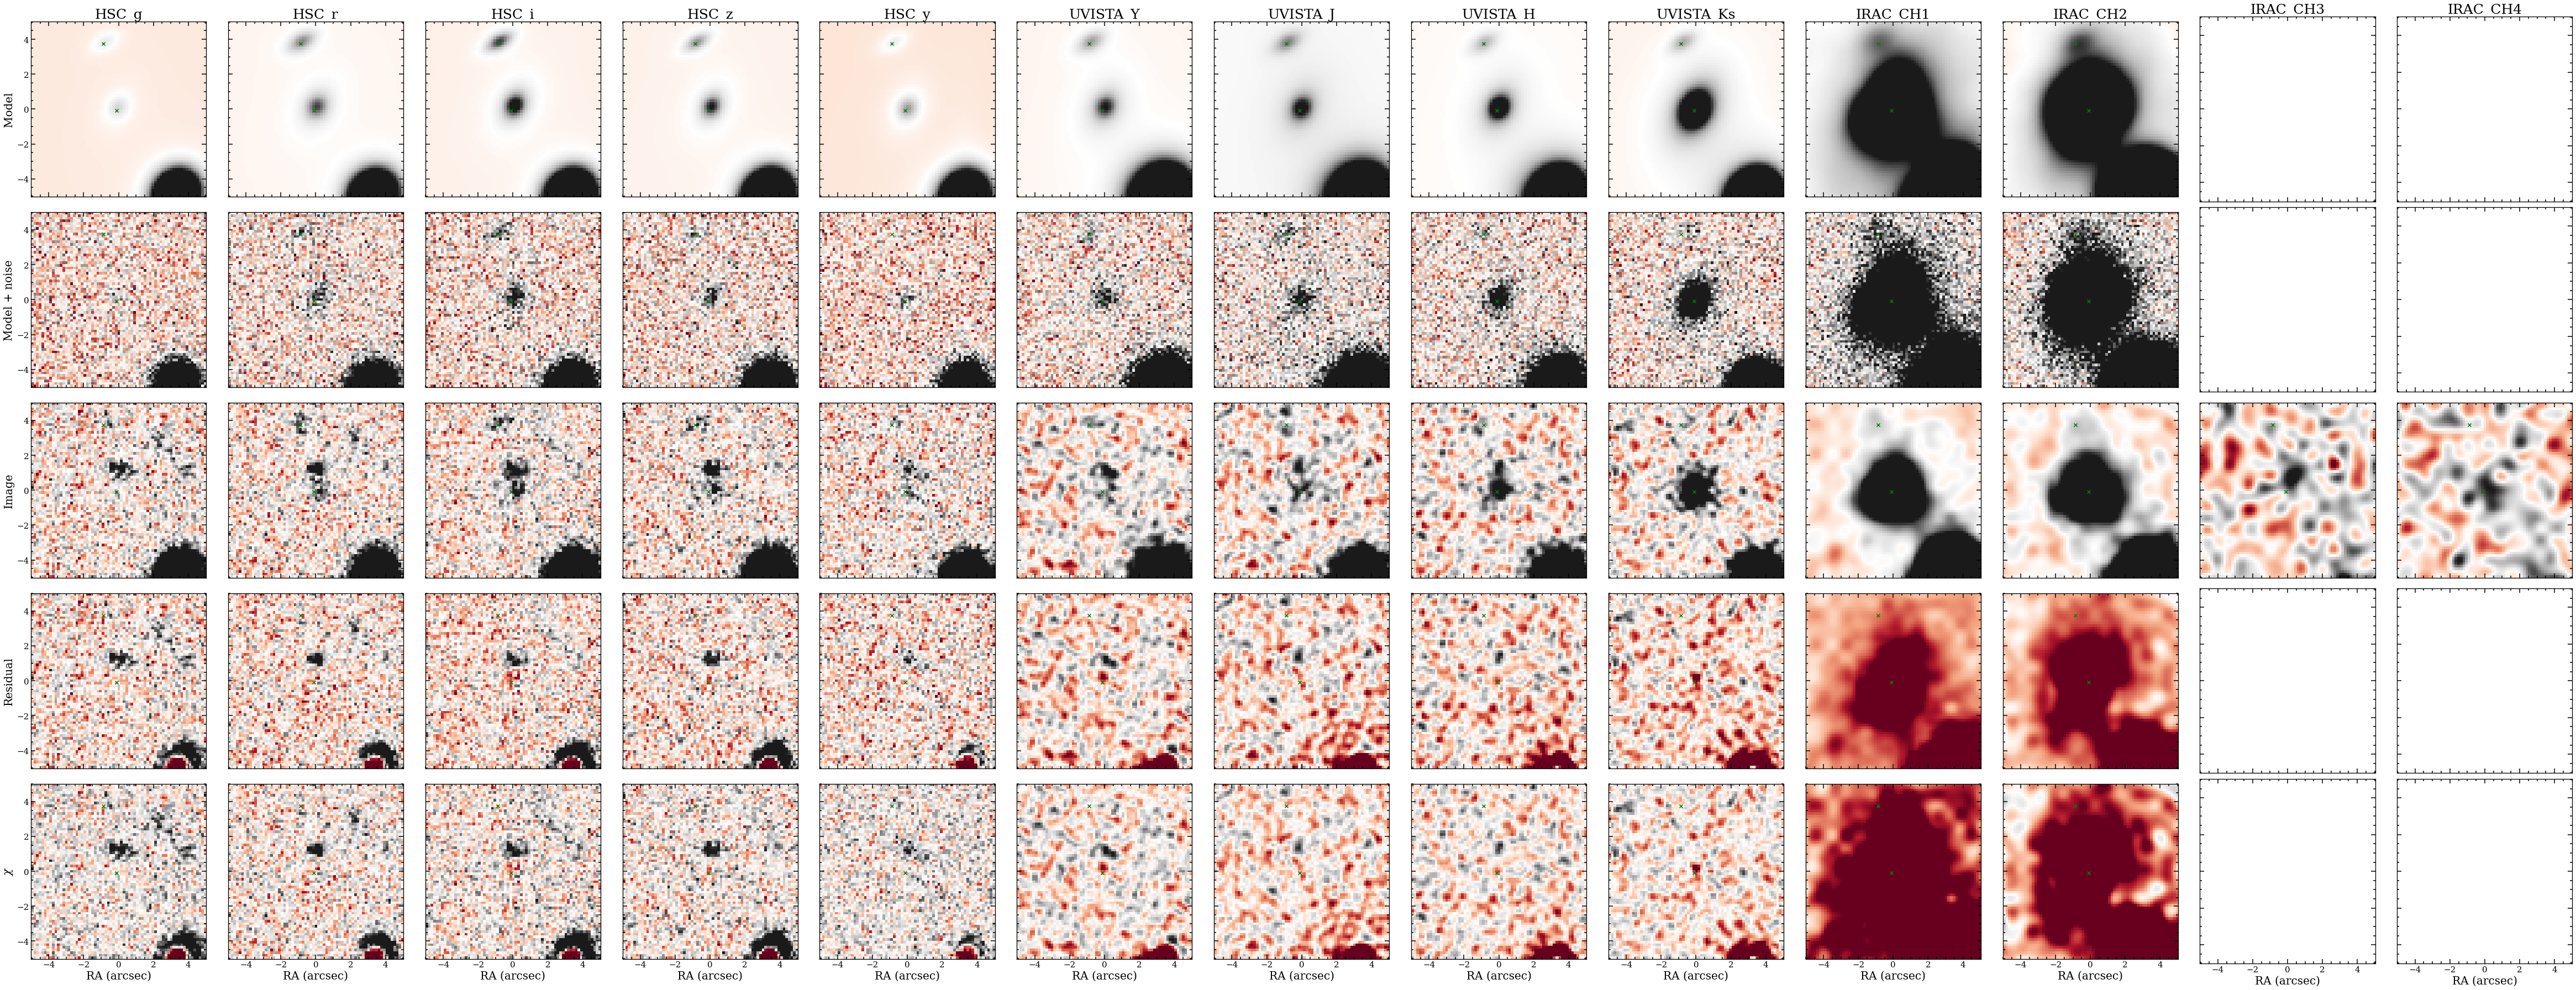

In [264]:
model_images, chi_images, res_images = tractorize(hdul, subset, bands)

# Show me what you got.
from astropy.stats import sigma_clipped_stats
import astropy.units as u

bands = list(cat.catalogs['Farmer'].bands[2:11]) + ['IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
coord0 = w.pixel_to_world(ny/2., nx/2.)
ra, dec = coord0.ra.value - subset['ALPHA_J2000'], subset['DELTA_J2000'] - coord0.dec.value
ra *= 3600
dec *= 3600
dw, dh = nx/2. * 0.15 , ny/2. * 0.15

fig, axes = plt.subplots(figsize=(5*len(bands), 5*5), ncols=len(bands), nrows=5, frameon=False, sharey=True, sharex=True) #, subplot_kw={'projection':w}, sharey=True)

for i, (band, ax) in enumerate(zip(bands, axes.T)):
    
    ax[2].scatter(ra, dec, marker='x', c='green')
    image = hdul[f'{band.upper()}'].data
    mean, med, std = sigma_clipped_stats(image)
    ax[2].imshow(image-med, origin='lower', cmap='RdGy', vmin=-3*std, vmax=3*std, aspect='equal', extent=[-dw, dw, -dh, dh])
    if i==0: ax[2].set_ylabel('Image')
    
    if band in ubands:

        ax[0].scatter(ra, dec, marker='x', c='green')
        image = model_images[band]
        ax[0].imshow(image-med, origin='lower', cmap='RdGy', vmin=-3*std, vmax=3*std, aspect='equal', extent=[-dw, dw, -dh, dh])
        if i == 0: ax[0].set_ylabel('Model')
            
        ax[1].scatter(ra, dec, marker='x', c='green')
        image = model_images[band] + std * np.random.normal(size=np.shape(model_images[band]))
        ax[1].imshow(image-med, origin='lower', cmap='RdGy', vmin=-3*std, vmax=3*std, aspect='equal', extent=[-dw, dw, -dh, dh])
        if i == 0: ax[1].set_ylabel('Model + noise')

        ax[3].scatter(ra, dec, marker='x', c='green')
        image = res_images[band]
        ax[3].imshow(image-med, origin='lower', cmap='RdGy', vmin=-3*std, vmax=3*std, aspect='equal', extent=[-dw, dw, -dh, dh])
        if i == 0: ax[3].set_ylabel('Residual')

        ax[4].scatter(ra, dec, marker='x', c='green')
        image = chi_images[band]
        ax[4].imshow(image-med, origin='lower', cmap='RdGy', vmin=-3, vmax=3, aspect='equal', extent=[-dw, dw, -dh, dh])
        if i == 0: ax[4].set_ylabel('$\chi$')
    
    ax[-1].set_xlabel(r'RA (arcsec)')
    ax[0].set_title(band, fontsize=25)
    
#     if i == 0:
#         ax[0].set_ylabel(r'Dec (arcsec)')

#         ax[0].set_title(band, fontsize=25)

fig.tight_layout()
fig.savefig(f'{CUTOUT_DIR}/{id}_fitting.pdf', overwrite=True)